# PyIndMach012: an example of user-model using DSS Python

This example runs a modified example from the OpenDSS distribution for the induction machine model with a sample PyIndMach012 implementation, written in Python, and the original, built-in IndMach012.

Check the `PyIndMach012.py` file for more comments. Comparing it to [the Pascal code for IndMach012](https://github.com/dss-extensions/dss_capi/blob/master/Version7/Source/PCElements/IndMach012.pas) can be useful to understand some of the inner workings of OpenDSS.

The user-model code in DSS Python is not stable yet but can be used to develop new ideas before commiting the final model in a traditional DLL user-model. Particularly, I (@PMeira) found some issues with callbacks with newer Version 8 COM DLLs, so changes related to that are expected.


In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from dss.UserModels import GenUserModel # used to get the DLL path
import PyIndMach012 # we need to import the model so it gets registered

/home/meira/projects/dss/dss_python/dss/__init__.py:19: UserWarning: Environment variable DSS_EXTENSIONS_DEBUG=1 is set: loading the debug version of the DSS C-API library
  warnings.warn('Environment variable DSS_EXTENSIONS_DEBUG=1 is set: loading the debug version of the DSS C-API library')


## The model class

In [2]:
??PyIndMach012

Type:        module
String form: <module 'PyIndMach012' from '/home/meira/Projects/dss/dss_python/docs/examples/UserModels/PyIndMach012/PyIndMach012.py'>
File:        ~/Projects/dss/dss_python/docs/examples/UserModels/PyIndMach012/PyIndMach012.py
Source:     
'''
A `dss_python` User-Model implementation of the IndMach012 Generator model from OpenDSS.

Based on the following files from the official OpenDSS source code:
- Source/PCElements/IndMach012.pas
- Source/IndMach012a/IndMach012Model.pas

This Python version was written by Paulo Meira. 
Original code by EPRI, licensed under the 3-clause BSD. See OPENDSS_LICENSE.

This sample code doesn't interact with the main OpenDSS interface directly,
it only uses the user-model interface. Thus, it is compatible with the official OpenDSS
distribution as well as DSS Python. Note that OpenDSS version 7 has a bug on 64-bit 
system and user-models most likely won't run via COM.

Recent version of OpenDSS 8 also present a bug when handling the editi

## OpenDSS setup

For this example, we can use either COM or DSS Python (DSS C-API). The IndMach012 model in DSS C-API seems to have a bug somewhere though -- this is being tracked in [dss_capi#62](https://github.com/dss-extensions/dss_capi/issues/62).

In [3]:
original_dir = os.getcwd() # same the original working directory since the COM module messes with it
USE_COM = True # toggle this value to run with DSS C-API
if USE_COM:
    from dss import patch_dss_com
    import comtypes.client
    DSS = patch_dss_com(comtypes.client.CreateObject('OpenDSSengine.DSS'))
    DSS.DataPath = original_dir
    os.chdir(original_dir)
else:
    from dss import DSS
    
DSS.Version    

'DSS C-API Library version DEV revision UNKNOWN based on OpenDSS SVN UNKNOWN [FPC 3.2.2] (64-bit build) MVMULT INCREMENTAL_Y CONTEXT_API PM DEBUG 20230311012603; License Status: Open '

In [4]:
Text = DSS.Text
Monitors = DSS.ActiveCircuit.Monitors

## Using the model

To use a Python model for generators:
- the model class needs to be registered in advance
- create a generator with `model=6`
    - pass a `usermodel="{dll_path}"` as in the following DSS command in the `run` function
    - pass a `"pymodel=MODELNAME"` parameter in the userdata property, where MODELNAME is the name of the model class in Python


In [5]:
def run(pymodel):
    Text.Command = 'redirect "master.dss"'

    if pymodel:
        # This uses our custom user-model in Python
        Text.Command = 'New "Generator.Motor1" bus1=Bg2 kW=1200 conn=delta kVA=1500.000 H=6 model=6 kv=0.48 usermodel="{dll_path}" userdata=(pymodel=PyIndMach012 purs=0.048 puxs=0.075 purr=0.018 puxr=0.12 puxm=3.8 slip=0.02 SlipOption=variableslip)'.format(
            dll_path=GenUserModel.dll_path,
        )
        Text.Command = 'New "Monitor.mfr2" element=Generator.Motor1 terminal=1 mode=3'
    else:
        # This uses the built-in model for comparison
        Text.Command = 'New "IndMach012.Motor1" bus1=Bg2 kW=1200 conn=delta kVA=1500.000 H=6 purs=0.048 puxs=0.075 purr=0.018 puxr=0.12 puxm=3.8 slip=0.02 SlipOption=variableslip kv=0.48'
        Text.Command = 'New "Monitor.mfr2" element=IndMach012.Motor1 terminal=1 mode=3'
        
    # This will run a power-flow solution
    Text.Command = 'Solve'
    
    # This will toggle to the dynamics mode
    Text.Command = 'Set mode=dynamics number=1 h=0.000166667'
    
    # And finally run 5000 steps for the dynamic simulation
    Text.Command = f'Solve number=5000'
   

In [10]:
# There are the channels from the Pascal/built-in IndMach012
channels_pas = ('Frequency', 'Theta (deg)', 'E1', 'dSpeed (deg/sec)', 'dTheta (deg)', 'Slip', 'Is1', 'Is2', 'Ir1', 'Ir2', 'Stator Losses', 'Rotor Losses', 'Shaft Power (hp)', 'Power Factor', 'Efficiency (%)')

# There are the channels from the Python module -- we define part of these and part come from the generator model itself
channels_py = ('Frequency', 'Theta (Deg)', 'E1_pu', 'dSpeed (Deg/sec)', 'dTheta (Deg)', 'Slip', 'Is1', 'Is2', 'Ir1', 'Ir2', 'StatorLosses', 'RotorLosses', 'ShaftPower_hp', 'PowerFactor', 'Efficiency_pct')

## Running and saving the outputs

Let's run the Pascal/built-in version of IndMach012 and our custom Python version for comparison:

In [8]:
Monitors.Header

['Frequency',
 'Theta (deg)',
 'E1',
 'Pshaft',
 'dSpeed (deg/sec)',
 'dTheta (deg)',
 'Slip',
 'puRs',
 'puXs',
 'puRr',
 'puXr',
 'puXm',
 'Maxslip',
 'Is1',
 'Is2',
 'Ir1',
 'Ir2',
 'Stator Losses',
 'Rotor Losses',
 'Shaft Power (hp)',
 'Power Factor',
 'Efficiency (%)']

In [11]:
run(False)
Monitors.Name = 'mfr2'
header = [x.strip() for x in Monitors.Header]
outputs_pas = {channel: Monitors.Channel(header.index(channel) + 1) for channel in channels_pas}

run(True)
Monitors.Name = 'mfr2'
header = [x.strip() for x in Monitors.Header]
outputs_py = {channel: Monitors.Channel(header.index(channel) + 1) for channel in channels_py}

time = np.arange(1, 5000 + 1) * 0.000166667
offset = int(0.1 / 0.000166667)

## Plotting the various output channels

The example circuit applies a fault at 0.3 s, isolating the machine at 0.4s (check `master.dss` for more details).

As we can see from the figures below, the outputs match very closely. After the induction machine is isolated, the efficiency and power factor values can misbehave as the power goes to zero, seem especially in the Pascal version.

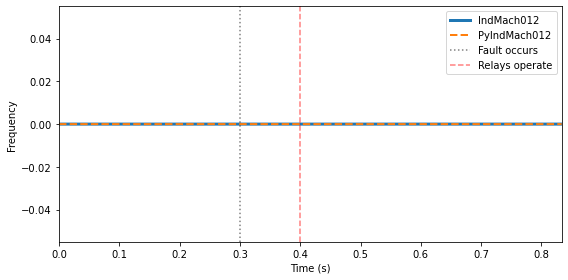

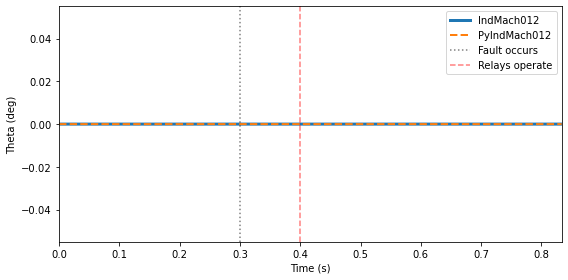

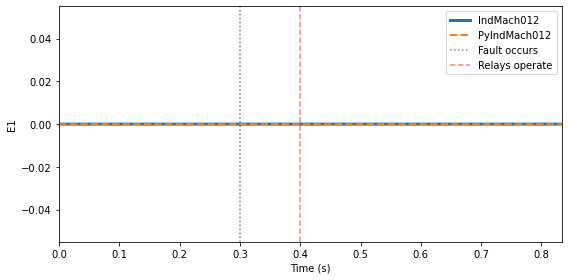

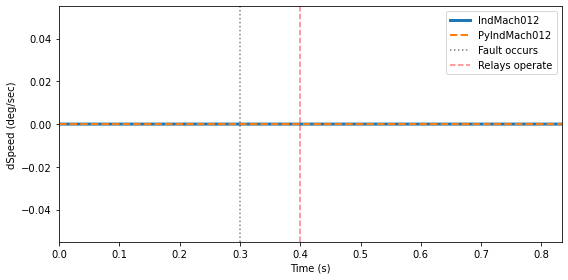

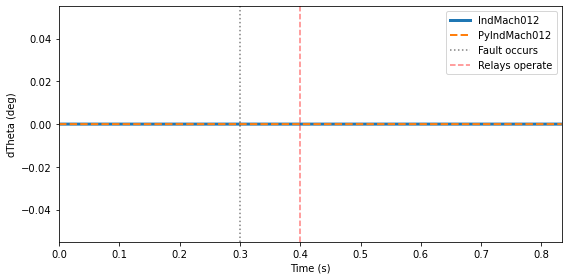

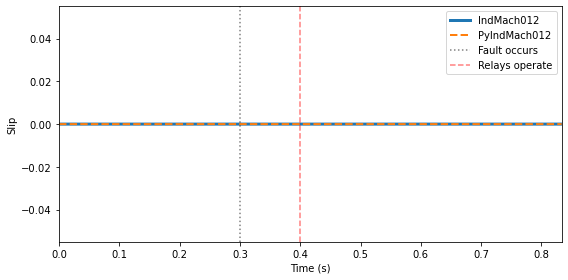

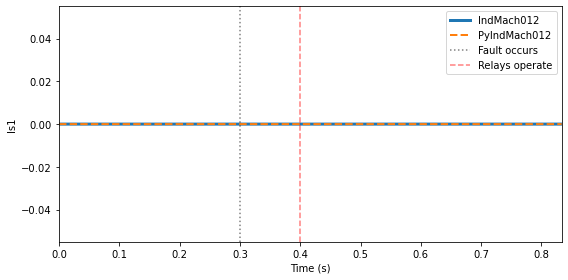

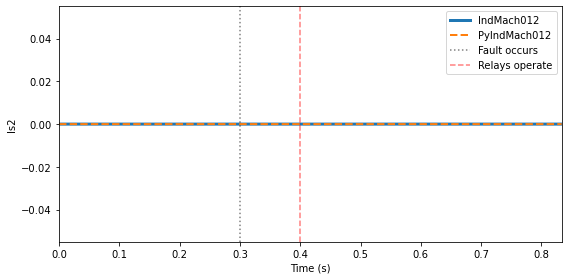

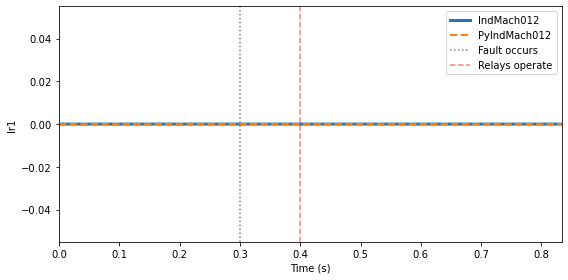

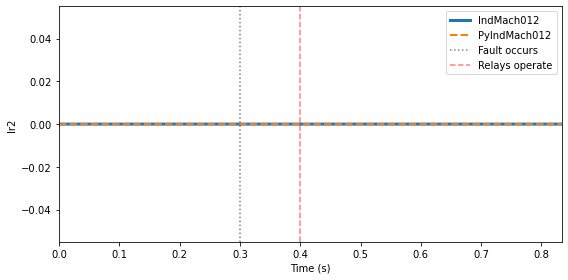

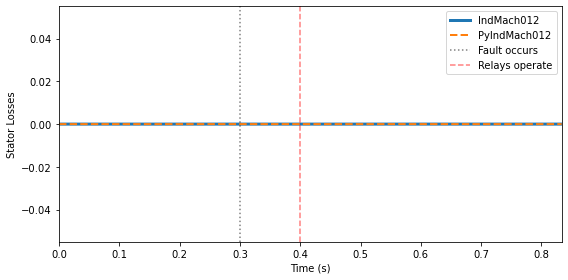

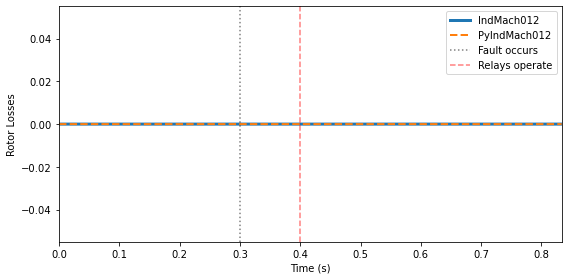

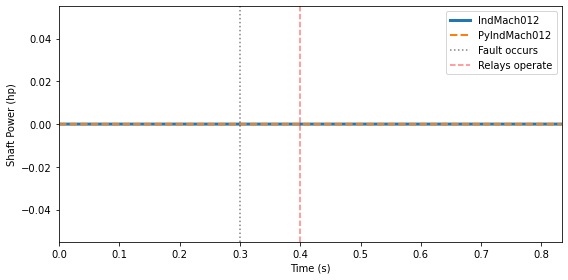

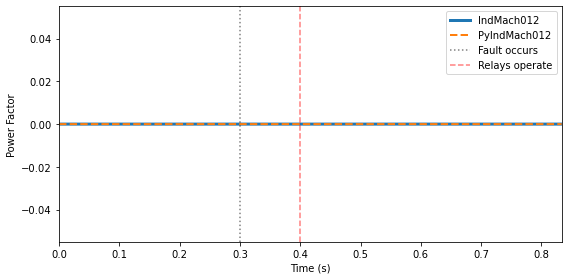

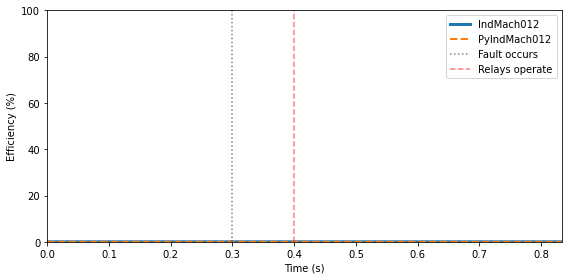

In [12]:
for ch_pas, ch_py in zip(channels_pas, channels_py):
    plt.figure(figsize=(8,4))
    plt.plot(time, outputs_pas[ch_pas], label='IndMach012', lw=3)
    plt.plot(time, outputs_py[ch_py], label='PyIndMach012', ls='--', lw=2)
    plt.axvline(0.3, linestyle=':', color='k', alpha=0.5, label='Fault occurs')
    plt.axvline(0.4, linestyle='--', color='r', alpha=0.5, label='Relays operate')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel(ch_pas)
    
    if ch_pas == 'Efficiency (%)':
        # Limit efficiency to 0-100
        plt.ylim(0, 100)
        
    plt.xlim(0, time[-1])
    plt.tight_layout()
    